# Solving an inverse problem

In [27]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
import numpy as np
import torch
import tensorboard, datetime
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
%matplotlib inline

## PDE

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x,y) \text{ for } x \in (0,1),  y \in (0,1)$

$u(x) = \sin(2\pi x)\sin(2\pi y)$

$f(x, y)$ is unknown, but we are given training samples $\{x_i, y_i, u_i\}$

## Training data

In [29]:
def u_true(x, y):
    return np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)
def f_true(x,y):
    return -8*(torch.pi)*(torch.pi)*torch.sin(torch.pi*x*2)*torch.sin(torch.pi*y*2)

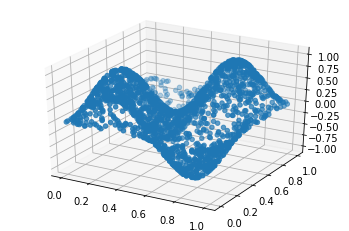

In [30]:
x_train = np.random.rand(2000)
y_train = np.random.rand(2000)
u_train = u_true(x_train, y_train)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train, y_train, u_train)

In [31]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 2)
        
    def forward(self, x, y):
        xt = torch.cat([x, y], dim=1)
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [32]:
torch.manual_seed(23939)
model = ffnn(15, 2)

lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 10000
loss_history = []

## Loss = MSE(u - u_i) + MSE(r_i)

def loss_function(model, x, y, u_true): 
    output = model(x, y)
    u = output[:, 0][:, None]
    f = output[:, 1][:, None]  
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    loss_res = torch.pow(u_xx+u_yy-f, 2).mean()
    loss = 1000* torch.pow(u-u_true, 2).mean()

    return loss_res+loss


In [33]:
n_train = 100
x = torch.linspace(0,1, n_train, requires_grad=True)
y = torch.linspace(0,1, n_train, requires_grad=True)
x_m, y_m = torch.meshgrid(x, y)
x = x_m.reshape(-1, 1)
y = y_m.reshape(-1, 1)

In [34]:
u = torch.tensor(u_true(x.detach().numpy(),y.detach().numpy()), requires_grad=True)

## Task

Use a PINN to find $u(x, y)$ and $f(x, y)$

In [36]:
for i in trange(n_epochs):
    loss = loss_function(model, x, y, u)
    opt.zero_grad()
    loss_history.append(loss.item())
    
    loss.backward()
    opt.step()

    # if i % 1000 == 0:
    #     print(f'epoch {i}, loss = {loss}')

100%|██████████| 10000/10000 [08:58<00:00, 18.58it/s]


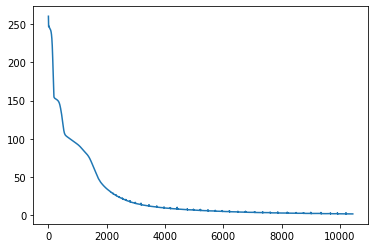

In [37]:
plt.plot(loss_history)

Text(0, 0.5, 'y')

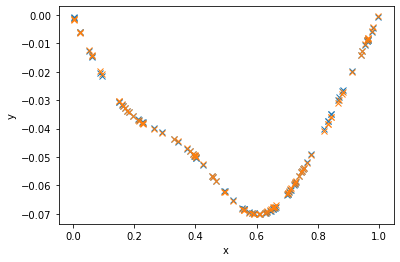

In [ ]:
x_ = x.detach().numpy()
y_ = model(x)[:, 0].detach().numpy()
%matplotlib inline
plt.plot(x_train, u_train, 'x', label = "org")
plt.plot(x_train, y_, 'x', label = "pred")
plt.xlabel('x')
plt.ylabel('y')

<function matplotlib.pyplot.show(*args, **kw)>

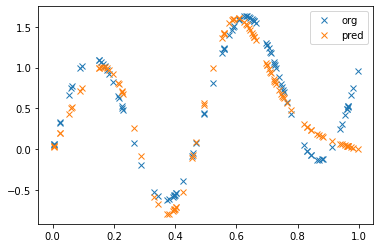

In [ ]:
y_1 = model(x)[:, 1].detach().numpy()
def f_true(x):
    return (1/48)*(48*x + (3/np.pi**2)*((4*np.pi)**2)*np.sin(4*np.pi*x))
f_true = f_true(x_train)
plt.plot(x_train, f_true, 'x', label = "org")
plt.plot(x_train, y_1, 'x', label = "pred")
plt.legend()
plt.show